## Import libraries

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gurobipy import *
from collections import defaultdict
import csv
from datetime import datetime
import os
import random


## Read and preprocess data


In [30]:
def load_data(file_path):
    data_dict = dict()

    with open(file_path) as file:
        reader = csv.DictReader(file)
        for row in reader:
            if row['Numéro du groupe'] != '':
                heures, minutes, _ = map(int, row['TransitTime'].split(':')) 
                total_minutes = heures * 60 + minutes
                data_dict[int(float(row['Numéro du groupe']))] = (
                    int(float(row['Femmes'])),
                    int(float(row['Hommes'])),
                    int(float(row['WCHR'])),
                    total_minutes
                )

    return data_dict

# Load data for each file

file_names = ["DataSeating 2024.csv","22Oct.csv","23Oct.csv","24Oct.csv","30Oct.csv", "5Nov.csv", "7Nov.csv", "Imaginary.csv"]
data_directory = 'data'
# for eachy dictionary : dict[Numéro du groupe : (Femmes, Hommes, WCHR, TransitTime)]
Oct21, Oct22,Oct23, Oct24, Oct30, Nov5, Nov7, Imaginary= [load_data(os.path.join(data_directory, file)) for file in file_names]

Transforming data to access each passenger's Id


In [31]:
def create_passengers_dict(data):
    passengers_dict = {}
    j = 1

    for group_num, group_data in data.items():
        weights = {'Femmes': 70, 'Hommes': 85, 'WCHR': 10000}  # Weight per passenger

        # Extracting data
        femmes, hommes, wchr, total_minutes = group_data

        # Enumerating passengers
        for _ in range(femmes + hommes + wchr):
            if femmes > 0:
                weight = weights['Femmes']
                passengers_dict[j] = {'gender': 'Femmes', 'group': group_num, 'weight': weight,
                                      'connection_time': total_minutes}
                femmes -= 1
            elif hommes > 0:
                weight = weights['Hommes']
                passengers_dict[j] = {'gender': 'Hommes', 'group': group_num, 'weight': weight,
                                      'connection_time': total_minutes}
                hommes -= 1
            else:
                weight = weights['WCHR']
                passengers_dict[j] = {'gender': 'WCHR', 'group': group_num, 'weight': weight,
                                      'connection_time': total_minutes}
                wchr -= 1
            j += 1

    return passengers_dict

Passengers_Oct21 = create_passengers_dict(Oct21)
Passengers_Oct22 = create_passengers_dict(Oct22)
Passengers_Oct23 = create_passengers_dict(Oct23)
Passengers_Oct24 = create_passengers_dict(Oct24)
Passengers_Oct30 = create_passengers_dict(Oct30)
Passengers_Nov5 = create_passengers_dict(Nov5)
Passengers_Nov7 = create_passengers_dict(Nov7)
Passengers_Imaginary = create_passengers_dict(Imaginary)


# Example usage for Nov5
print(Passengers_Nov5)

{1: {'gender': 'Femmes', 'group': 1, 'weight': 70, 'connection_time': 0}, 2: {'gender': 'Hommes', 'group': 1, 'weight': 85, 'connection_time': 0}, 3: {'gender': 'Hommes', 'group': 1, 'weight': 85, 'connection_time': 0}, 4: {'gender': 'Hommes', 'group': 2, 'weight': 85, 'connection_time': 60}, 5: {'gender': 'Femmes', 'group': 3, 'weight': 70, 'connection_time': 165}, 6: {'gender': 'Hommes', 'group': 3, 'weight': 85, 'connection_time': 165}, 7: {'gender': 'Femmes', 'group': 4, 'weight': 70, 'connection_time': 0}, 8: {'gender': 'Hommes', 'group': 4, 'weight': 85, 'connection_time': 0}, 9: {'gender': 'WCHR', 'group': 4, 'weight': 10000, 'connection_time': 0}, 10: {'gender': 'Femmes', 'group': 5, 'weight': 70, 'connection_time': 0}, 11: {'gender': 'Femmes', 'group': 5, 'weight': 70, 'connection_time': 0}, 12: {'gender': 'Femmes', 'group': 5, 'weight': 70, 'connection_time': 0}, 13: {'gender': 'Femmes', 'group': 6, 'weight': 70, 'connection_time': 0}, 14: {'gender': 'Hommes', 'group': 6, 'we

# Static model

In [32]:
# Function to create optimization model and variables

ranks = 29  # number of rows in the aircraft
ns = 7 * ranks  # number of seats

def create_model_and_variables(passengers_dict):
    n = len(passengers_dict)  # number of passengers

    m = Model('statique')  # Model initialization

    # Adding variables
    S = {(i, j): m.addVar(vtype=GRB.BINARY, name=f'j{i}') for i in range(1, n + 1) for j in range(1, ns + 1)}

    # Adding constraints
    # Max. 1 seat per passenger
    for j in range(1, ns + 1):
        m.addConstr(quicksum(S[(i, j)] for i in range(1, n + 1)) <= 1, name="PassengerMax")

    # Each passenger has one and only one seat
    for i in range(1, n + 1):
        m.addConstr(quicksum(S[(i, j)] for j in range(1, ns + 1)) == 1, name="SeatMax")

    # The central aisle is left free
    for i in range(1, n + 1):
        for j in range(1, ns + 1):
            if j % 7 == 4:
                m.addConstr(S[(i, j)] == 0)

    # Baricenter
    x_g = LinExpr()
    y_g = LinExpr()

    total_weight = quicksum(passengers_dict[i]['weight'] for i in range(1, n + 1)).getValue()

    for i in range(1, n + 1):
        j_k = 1

        for j in range(1, ns + 1):
            weight_ij = passengers_dict[i]['weight'] / total_weight

            if j % 7 == 0:
                x_g += (7 * S[i, j] * weight_ij)
                y_g += (j_k * S[i, j] * weight_ij)
                j_k += 1
            else:
                x_g += ((j % 7) * S[i, j] * weight_ij)
                y_g += (((j // 7) + 1) * S[i, j] * weight_ij)

    m.addConstr(x_g >= 3)
    m.addConstr(x_g <= 5)
    m.addConstr(y_g >= 13)
    m.addConstr(y_g <= 17)

    # Disabled passengers occupy 4 spaces on the central aisle
    for passenger in passengers_dict:
        if passengers_dict[passenger]['gender']=='WCHR':
            #Seats are shortened by row (from 7 to 7)
            for j in range(1, ns+1-8, 7):             
            
                x1, x2, x3, x4, x5, x6, x7 = j,j+1,j+2,j+3,j+4,j+5,j+6
                
                #A seat is fixed in rows 3 or 5.
                m.addConstr(S[(passenger, x1)] + S[(passenger, x2)] +  S[(passenger, x6)] + S[(passenger, x7)] ==0 )   
                
                #The seat overlooking the alley is closed off
                m.addConstr(S[(passenger, x3)]+sum(S[(i, x3-1)] for i in passengers_dict) <= 1) 
                #We close the 2 seats behind
                m.addConstr(S[(passenger, x3)]+sum(S[(i, x3+7)] for i in passengers_dict) <= 1) 
                m.addConstr(S[(passenger, x3)]+sum(S[(i, x3+6)] for i in passengers_dict) <= 1)
                #The seat overlooking the alley is closed off
                m.addConstr(S[(passenger, x5)]+sum(S[(i, x5+1)] for i in passengers_dict) <= 1) 
                #We close the 2 seats behind
                m.addConstr(S[(passenger, x5)]+sum(S[(i, x5+7)] for i in passengers_dict) <= 1) 
                m.addConstr(S[(passenger, x5)]+sum(S[(i, x5+8)] for i in passengers_dict) <= 1)
            #Disabled passengers cannot be in the last row   
            m.addConstr(sum(S[(passenger, k)] for k in range (ns-6, ns+1)) == 0)  

    return m, S

In [33]:
#Choice of the dictionnary

Passengers=Passengers_Nov5

In [34]:
# Create models and variables for each date
n=len(Passengers)
m, S = create_model_and_variables(Passengers)


Objective functions

In [35]:
# Transit passengers are seated at the front of the aircraft
def obj_transit(S, passengers_dict):
    T = {}

    for passenger in passengers_dict:
        if passengers_dict[passenger]['connection_time'] > 0:  # transit passenger
            T[passenger] = passengers_dict[passenger]['connection_time']

    P = list(T.keys())  # returns a list of transit passenger identifiers

    f = 0
    for k in range(len(P)):
        for j in range(1, ns + 1):
            q = (j - 1) // 7
            f += S[(P[k], j)] * (1 / T[P[k]]) * q

    return f


In [36]:
def seat_coordinates(seats):  #seats is a list
    coordinates = []
    for j in range(len(seats)):
        if (seats[j] % 7 == 0):
            x = 7
            y = (seats[j] // 7) 
        else:
            x = seats[j] % 7
            y = (seats[j] // 7) +1 
        coordinates.append((x, y))
    return coordinates

print (seat_coordinates([1, 54]))

[(1, 1), (5, 8)]


In [37]:
alpha=0.3

def obj_dist(Passengers, alpha):

    obj = LinExpr()
    X={}
    Y={}
    coord = seat_coordinates([j for j in range(1, ns+1)])
    for i in range(1, n + 1):
        X[i]=m.addVar(vtype=GRB.INTEGER)
        Y[i]=m.addVar(vtype=GRB.INTEGER)

        for k in range(i + 1, n + 1):  
            if  i!=k and Passengers[i]['group'] == Passengers[k]['group']:  #Si passager i et passager k sont dans le même groupe

                xi, yi = 0, 0
                xk, yk = 0, 0

                for j in range (len(coord)):                                      #On parcourt les sièges
                    xi, yi = xi + S[(i,j+1)]*coord[j][0], yi + S[(i,j+1)]*coord[j][1]
                    xk, yk =  xk + S[(k,j+1)]*coord[j][0], yk + S[(k,j+1)]*coord[j][1]
                
                m.addConstr(X[i]>=xi - xk)
                m.addConstr(X[i]>= -xi + xk)
                m.addConstr(Y[i]>=yi - yk)
                m.addConstr(Y[i]>= -yi + yk)
                dist_x = X[i] 
                dist_y = Y[i]
                obj += alpha*dist_x + (1-alpha)*dist_y  
                
    return obj



In [38]:

m.setObjective(obj_transit(S, Passengers) + obj_dist(Passengers, alpha) , GRB.MINIMIZE)

In [39]:
# Choice of minimalist display settings
m.params.outputflag = 0 # mute mode
m.update() # Model update
display(m) # Text mode display of PL



<gurobi.Model MIP instance statique: 4193 constrs, 19885 vars, Parameter changes: Username=(user-defined), OutputFlag=0>

In [40]:
#Resolution
m.Params.timeLimit = 50
m.optimize()
# Solution display 
print()
print("Seats on the plane are as follows:", [(i, j) for i in range(1, len(Passengers) + 1) for j in range(1, ns + 1) if S[(i, j)].x])




Seats on the plane are as follows: [(1, 76), (2, 77), (3, 75), (4, 8), (5, 27), (6, 26), (7, 194), (8, 195), (9, 192), (10, 93), (11, 85), (12, 86), (13, 177), (14, 178), (15, 16), (16, 17), (17, 164), (18, 3), (19, 5), (20, 1), (21, 2), (22, 56), (23, 154), (24, 70), (25, 69), (26, 146), (27, 201), (28, 203), (29, 202), (30, 138), (31, 139), (32, 12), (33, 83), (34, 107), (35, 108), (36, 159), (37, 22), (38, 23), (39, 37), (40, 30), (41, 132), (42, 133), (43, 131), (44, 48), (45, 49), (46, 135), (47, 136), (48, 169), (49, 126), (50, 19), (51, 14), (52, 13), (53, 90), (54, 98), (55, 91), (56, 89), (57, 141), (58, 143), (59, 148), (60, 150), (61, 149), (62, 184), (63, 183), (64, 190), (65, 176), (66, 21), (67, 20), (68, 117), (69, 118), (70, 7), (71, 6), (72, 54), (73, 99), (74, 105), (75, 103), (76, 71), (77, 73), (78, 134), (79, 28), (80, 167), (81, 168), (82, 175), (83, 174), (84, 173), (85, 10), (86, 9), (87, 15), (88, 62), (89, 63), (90, 61), (91, 29), (92, 153), (93, 59), (94, 12

In [41]:
def valeurs_var(S) :
    val = {}
    for i in Passengers :
        for j in range(1,ns+1) :
            if S[(i,j)].x :
                val[(i,j)] = 1
            else :
                val[(i,j)] = 0
    return(val)
valeurs_S = valeurs_var(S)
print(valeurs_S)

{(1, 1): 0, (1, 2): 0, (1, 3): 0, (1, 4): 0, (1, 5): 0, (1, 6): 0, (1, 7): 0, (1, 8): 0, (1, 9): 0, (1, 10): 0, (1, 11): 0, (1, 12): 0, (1, 13): 0, (1, 14): 0, (1, 15): 0, (1, 16): 0, (1, 17): 0, (1, 18): 0, (1, 19): 0, (1, 20): 0, (1, 21): 0, (1, 22): 0, (1, 23): 0, (1, 24): 0, (1, 25): 0, (1, 26): 0, (1, 27): 0, (1, 28): 0, (1, 29): 0, (1, 30): 0, (1, 31): 0, (1, 32): 0, (1, 33): 0, (1, 34): 0, (1, 35): 0, (1, 36): 0, (1, 37): 0, (1, 38): 0, (1, 39): 0, (1, 40): 0, (1, 41): 0, (1, 42): 0, (1, 43): 0, (1, 44): 0, (1, 45): 0, (1, 46): 0, (1, 47): 0, (1, 48): 0, (1, 49): 0, (1, 50): 0, (1, 51): 0, (1, 52): 0, (1, 53): 0, (1, 54): 0, (1, 55): 0, (1, 56): 0, (1, 57): 0, (1, 58): 0, (1, 59): 0, (1, 60): 0, (1, 61): 0, (1, 62): 0, (1, 63): 0, (1, 64): 0, (1, 65): 0, (1, 66): 0, (1, 67): 0, (1, 68): 0, (1, 69): 0, (1, 70): 0, (1, 71): 0, (1, 72): 0, (1, 73): 0, (1, 74): 0, (1, 75): 0, (1, 76): 1, (1, 77): 0, (1, 78): 0, (1, 79): 0, (1, 80): 0, (1, 81): 0, (1, 82): 0, (1, 83): 0, (1, 84): 0, 

Visualization of the seats

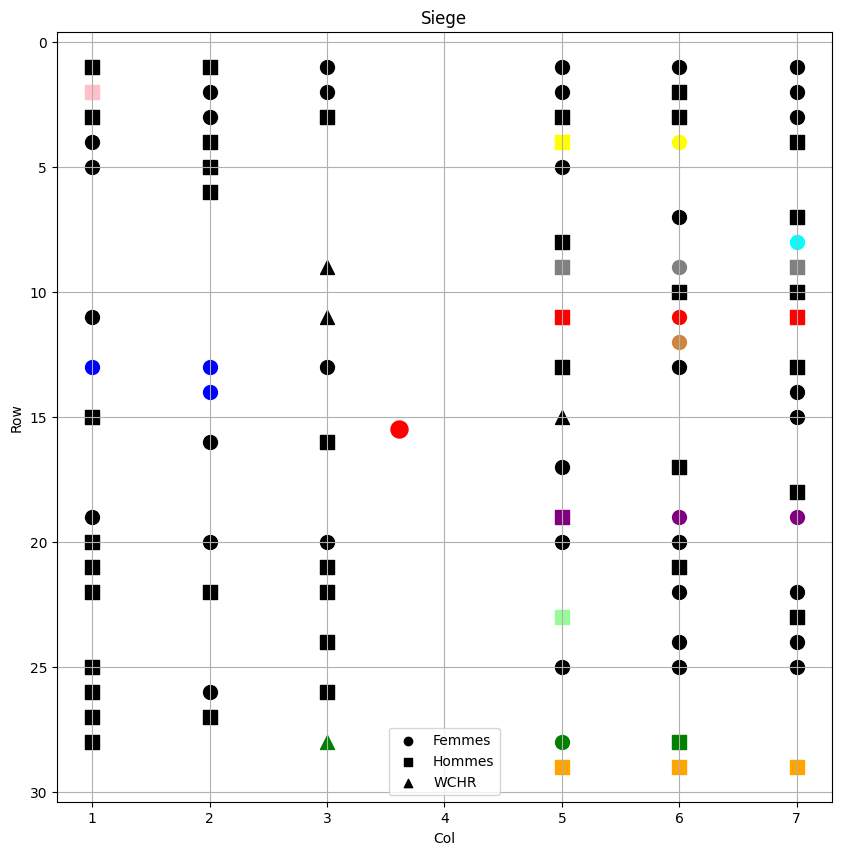

In [67]:
def visualization_tool(S) :
    # Creating a variable called seats containing only the j coordinates
    seats = [j for i in range(1, n + 1) for j in range(1, ns + 1) if (valeurs_S[(i,j)]==1)]
    seat_coords = seat_coordinates(seats)


    # Display the Baricenter

    def calculate_center_of_mass(seat_coords, Passengers):
        x_g = LinExpr()
        y_g = LinExpr()
        total_weight = quicksum(Passengers[i]['weight'] for i in range(1, n + 1)).getValue()

        for i in range(1, n + 1):
            j_k = 1

            for j in range(1, ns + 1):
                weight_ij = Passengers[i]['weight'] / total_weight

                if (j % 7 == 0):
                    x_g += (7 * S[i, j] * weight_ij)
                    y_g += (j_k * S[i, j] * weight_ij)
                    j_k += 1
                else:
                    x_g += ((j % 7) * S[i, j] * weight_ij)
                    y_g += (((j // 7) + 1) * S[i, j] * weight_ij)

        return x_g, y_g


    x_g, y_g = calculate_center_of_mass(seat_coords, Passengers)



    # Dictionary to count the frequency of each group
    group_counts = defaultdict(int)

    # Counting the frequency of each group
    for passenger in Passengers.values():
        group_counts[passenger['group']] += 1
    # Sort the groups by the number of passengers in each group in descending order
    sorted_groups = sorted(group_counts.items(), key=lambda x: x[1], reverse=True)

    # Print the groups in ascending order with the number of passengers in each group
    #print("Groups in ascending order with the number of passengers in each group:")
    #for group, count in sorted_groups:
    #    print(f"Group {group}: {count} passengers")

    # Define shapes for each gender
    shapes = {
        'Femmes': 'o',   # Circule
        'Hommes': 's',   # Square
        'WCHR': '^'      # Triangule
    }

    # Define colors for the groups with 3 passangers
    colors = {
        1: 'red',
        4: 'green',
        5: 'blue',
        14: 'orange',
        23: 'purple',
        46: 'gray',
        3: 'yellow',
        10: 'cyan',
        17: 'peru',
        19:'palegreen',
        2: 'pink'
    }

    plt.figure(figsize=(10, 10))
    for idx, coord in enumerate(seat_coords):
        group = Passengers[idx + 1]['group']
        gender = Passengers[idx + 1]['gender']
        color = colors.get(group, 'black')  # Get color for the group, default to black if not in colors dictionary
        shape = shapes.get(gender, 'o')      # Get shape for the gender, default to circle if not in shapes dictionary
        plt.scatter(coord[0], coord[1], color=color, marker=shape,  s=100)  # Use marker parameter to set the shape
        
    # Add labels for each gender
    for gender, shape in shapes.items():
        plt.scatter([], [], color='black', marker=shape, label=gender)  # Create invisible scatter plot to add label

    # Plotting the center of mass
    plt.scatter(x_g.getValue(), y_g.getValue(), color='red', marker='o', s=150)  # Larger red point for center of mass

    plt.xlabel('Col')
    plt.ylabel('Row')
    plt.title('Siege')
    plt.grid(True)
    plt.gca().invert_yaxis()
    plt.legend()  # Show legend with gender labels
    plt.show()
valeurs_S = valeurs_var(S)
visualization_tool(valeurs_S)

Evaluation de la satisfaction client

Première métrique qui évalue la satisfaction des passagers pris un par un.
Donc même si le groupe n'est pas bien groupé, si le passager est assis à côté d'au moins un des membres de son groupe, il est satisfait.

In [43]:
#Première métrique de la satisfaction client (chaque passager pris individuellement)
def metrique_groupe_passager():
    sat={}
    s=0
    for i in Passengers:
        sat[i]=0
        for k in Passengers :
            if k !=i and Passengers[i]['group'] == Passengers[k]['group']:
                for j in range (1, ns+1):
                    if S[(i,j)].x:
                        xi, yi = seat_coordinates([j])[0]
                    if S[(k,j)].x:
                        xk, yk = seat_coordinates([j])[0]
                if yi == yk and min([xi, xk]) == max([xi, xk])-1:
                    s = 1
                elif xi == xk and min([yi, yk]) == max([yi, yk])-1:
                    s = 1/2
                elif yi == yk and min([xi, xk]) == 3 and max([xi, xk]) == 5:
                    s = 1/2
            if sat[i] != 1:
                sat[i] = s
    
    return sat

print ( metrique_groupe_passager()) 

def metrique_transit_passager():
    sat= {}

    for i in Passengers:
        #On ne considère que les passagers dont le temps de correspondance est inférieur à 1h30
        if Passengers[i]['connection_time'] > 0 and Passengers[i]['connection_time'] <= 90: 
            for j in range (1, ns+1):
                
                if S[(i,j)].x:
                    x, y = seat_coordinates([j])[0]
                    if y <=5:
                        sat[i] = 1
                    elif y <= 7:
                        sat[i] = 0.5
                    else:
                        sat[i] =0
        else :
            sat[i]=1
                
    return sat
print (metrique_transit_passager()) 

def metrique_globale_passager():

    sat={}
    sat1=metrique_transit_passager()
    sat2=metrique_groupe_passager()
    satisfaction=0
     

    for i in Passengers:
        sat[i]=(sat1[i]+sat2[i])/2
        satisfaction +=sat[i]
    satisfaction = satisfaction/len(Passengers)

    return satisfaction, sat

satisfaction, sat= metrique_globale_passager()

print ("La satisfaction moyenne des clients est de ",satisfaction*100, "%" )

{1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 0.5, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 0.5, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 0.5, 65: 0.5, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1}
{1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 

Deuxième métrique : la satisfaction est évaluée à l'échelle du groupe et de manière strice, c'est à dire que certaines configurations sont jugées satisfaisantes, les autres ne l'étant pas.

In [44]:
#renvoie une liste contenant les indices des passagers dans le groupe de i
def groupe(i, Passengers):
    G=[]
    for k in range(1, n+1):
        if Passengers[i]['group'] == Passengers[k]['group']:
            G+=[k]
    return G


In [45]:
#renvoie un dictionnaire dont les groupes sont les clefs et les passagers du groupe les valeurs
def group_dict(Passengers):

    dic={}
    for i in Passengers:
        groupi=groupe(i, Passengers)
        k=Passengers[i]['group']
        if k not in dic:
            dic[k]=groupi
    return dic

group_dico=group_dict(Passengers)
  

In [46]:
def metrique_groupe_stricte (Passengers):
    sat={}
    
    group=group_dict(Passengers)

    for g in group:
        seats = [j for i in group[g] for j in range(1, ns + 1) if S[(i, j)].x]
        group_coord=seat_coordinates(seats)

        X=[]
        Y=[]
        for i in range (len(group[g])):
            X += [group_coord [i][0]]
            Y += [group_coord [i][1]]
            X.sort()
            Y.sort()

        if len(group[g]) == 1:
            sat[g] = 1

        #Groupe de 2 passagers : ils doivent être côte à côte. Satisfaction intermédiaire si séparés par allée centrale
        if len(group[g]) == 2:
            if Y[0] == Y[1]:
                if X[1] == X[0]+1:
                    sat[g] = 1
                elif (3 in X and 5 in X):
                    sat[g] = 1/2
                else : 
                    sat[g] = 0

            else : 
                sat[g] = 0

        #Groupe de 3 : aligné sur le même rang. Satisfaction max si côtes à côtes, intermédiaire si séparés par allée centrale, nulle sinon
        elif len(group[g]) == 3:
            if Y[0] == Y[1] and Y[0] == Y[2]:
                if X[1] == X[0]+1 and X[2] == X[1]+1:
                    sat[g] = 1

                elif (X[1] == X[0]+1 or X[2] == X[1]+1) and(3 in X and 5 in X):
                    sat[g] = 1/2
                else : 
                    sat[g] = 0
            else : 
                sat[g] = 0

        #Groupe de 4 à 6 personnes
        elif len(group[g]) <=6 :
            if all(y == Y[0] for y in Y):
                
                if X[len(group[g])-1]-X[0] == len(group):
                    sat[g]=1
                else:
                    sat[g]=1
            
            elif Y[1]==Y[0]+1:
                if (3 in X and 5 not in X) or (5 in X and 3 not in X):
                    sat[g]=1/2
                else:
                    sat[g]=0
            else :
                sat[g]=0   
                
        else:
            sat[g]=1


    return sat        
            

In [47]:
#Retourne une note sur 1 par passager concernant l'objectif de transit
def metrique_transit_stricte(Passengers):

    sat= {}
    

    for i in Passengers:
        #On ne considère que les passagers dont le temps de correspondance est inférieur à 1h30
        if Passengers[i]['connection_time'] > 0 and Passengers[i]['connection_time'] <= 90: 
            for j in range (1, ns+1):
                
                if S[(i,j)].x:
                    x, y = seat_coordinates([j])[0]
                    if y <=5:
                        sat[i] = 1
                    elif y <= 7:
                        sat[i] = 1/2
                    elif y <= 10:
                        sat[i] = 1/3
                    else:
                        sat[i] =0
        else :
            sat[i]=1
                
    return sat



In [48]:
def metrique_globale_stricte(Passengers):
    sat={}
    moyenne=0
    sat_groupe=0
    sat_transit=0
    #Pour fusionner les notes des passagers au regard des deux fonctions objectif, on transforme les notes par groupe pour la fonction groupe en note par passager
    sat1={}
    s=metrique_groupe_stricte (Passengers)
    group_dico=group_dict(Passengers)
    for g in group_dico:
        sat_groupe += s[g]
        passagers = group_dico[g]
        for i in passagers:
            sat1[i]=s[g]

    sat2=metrique_transit_stricte(Passengers)

    for i in Passengers:
        sat[i]=(sat1[i] + sat2[i])/2
        moyenne += sat[i]
        sat_transit += sat2[i]
        

    moyenne = moyenne / len(Passengers)
    sat_groupe = sat_groupe / len(s)
    sat_transit =sat_transit / len(Passengers)
    # print (list(sat.values()))
    # m=min(list(sat.values()))
    # M=max(list(sat.values()))
    return moyenne, sat_transit, sat_groupe

    
    

In [49]:


moyenne, s_transit, s_groupe = metrique_globale_stricte(Passengers)

# print ("Le pire niveau de satisfaction est de ", m*100, "%")
# print ("Le meilleur niveau de satisfaction est de ", M*100, "%")
print ("La satisfaction moyenne des passagers est de ", moyenne*100, "%")
print ("La satisfaction moyenne des passagers en transit est de ", s_transit)
print ("La satisfaction moyenne des groupes est de ", s_groupe)



La satisfaction moyenne des passagers est de  86.34020618556701 %
La satisfaction moyenne des passagers en transit est de  1.0
La satisfaction moyenne des groupes est de  0.8557692307692307


Post Processing

In [55]:
def metrique_groupe_stricte(Passengers,valeurs_S):
    sat={}
    group=group_dict(Passengers)
    for g in group:
        seats = [j for i in group[g] for j in range(1, ns + 1) if valeurs_S[(i, j)]]
        group_coord=seat_coordinates(seats)
        X=[]
        Y=[]
        for i in range (len(group[g])):
            X += [group_coord [i][0]]
            Y += [group_coord [i][1]]
            X.sort()
            Y.sort()
        if len(group[g]) == 1:
            sat[g] = 1
        #Groupe de 2 passagers : ils doivent être côte à côte. Satisfaction intermédiaire si séparés par allée centrale
        if len(group[g]) == 2:
            if Y[0] == Y[1]:
                if X[1] == X[0]+1:
                    sat[g] = 1
                elif (3 in X and 5 in X):
                    sat[g] = 1/2
                else : 
                    sat[g] = 0
            else : 
                sat[g] = 0
        #Groupe de 3 : aligné sur le même rang. Satisfaction max si côtes à côtes, intermédiaire si séparés par allée centrale, nulle sinon
        elif len(group[g]) == 3:
            if Y[0] == Y[1] and Y[0] == Y[2]:
                if X[1] == X[0]+1 and X[2] == X[1]+1:
                    sat[g] = 1
                elif (X[1] == X[0]+1 or X[2] == X[1]+1) and(3 in X and 5 in X):
                    sat[g] = 1/2
                else : 
                    sat[g] = 0
            else : 
                sat[g] = 0
        #Groupe de 4 à 6 personnes
        elif len(group[g]) <=6 :
            if all(y == Y[0] for y in Y):
                if X[len(group[g])-1]-X[0] == len(group):
                    sat[g]=1
                else:
                    sat[g]=0
            elif Y[1]==Y[0]+1:
                if (3 in X and 5 not in X) or (5 in X and 3 not in X):
                    sat[g]=1/2
                else:
                    sat[g]=0
            else :
                sat[g]=0   
        else:
            sat[g]=1
    return sat        
#Retourne une note sur 1 par passager concernant l'objectif de transit
def metrique_transit_stricte(Passengers):
    sat= {}
    for i in Passengers:
        #On ne considère que les passagers dont le temps de correspondance est inférieur à 1h30
        if Passengers[i]['connection_time'] > 0 and Passengers[i]['connection_time'] <= 90: 
            for j in range (1, ns+1):
                
                if S[(i,j)].x:
                    x, y = seat_coordinates([j])[0]
                    if y <=5:
                        sat[i] = 1
                    elif y <= 7:
                        sat[i] = 1/2
                    elif y <= 10:
                        sat[i] = 1/3
                    else:
                        sat[i] =0
        else :
            sat[i]=1         
    return sat
def metrique_globale_stricte(Passengers,valeurs_S):
    sat={}
    moyenne=0
    sat_groupe=0
    sat_transit=0
    #Pour fusionner les notes des passagers au regard des deux fonctions objectif, on transforme les notes par groupe pour la fonction groupe en note par passager
    sat1={}
    s=metrique_groupe_stricte (Passengers,valeurs_S)
    group_dico=group_dict(Passengers)
    for g in group_dico:
        sat_groupe += s[g]
        passagers = group_dico[g]
        for i in passagers:
            sat1[i]=s[g]
    sat2=metrique_transit_stricte(Passengers)
    for i in Passengers:
        sat[i]=(sat1[i] + sat2[i])/2
        moyenne += sat[i]
        sat_transit += sat2[i]
    moyenne = moyenne / len(Passengers)
    sat_groupe = sat_groupe / len(s)
    sat_transit =sat_transit / len(Passengers)
    return moyenne, sat_transit, sat_groupe
valeurs_S = valeurs_var(S)
moyenne, s_transit, s_groupe = metrique_globale_stricte(Passengers,valeurs_S)
# print ("Le pire niveau de satisfaction est de ", m*100, "%")
# print ("Le meilleur niveau de satisfaction est de ", M*100, "%")
print ("La satisfaction moyenne des passagers est de ", moyenne*100, "%")
print ("La satisfaction moyenne des passagers en transit est de ", s_transit)
print ("La satisfaction moyenne des groupes est de ", s_groupe)  
    
         
            
            
            
            
            

def post_checking(valeurs_S) :
    moyenne, s_transit, s_groupe = metrique_globale_stricte(Passengers,valeurs_S)
    bool = True
    valeurs_S_new = valeurs_S.copy()
    for i1 in Passengers:
        for i2 in Passengers :
            if (i1 != i2) and (Passengers[i1]['gender'] != 'WCHR') and (Passengers[i2]['gender'] != 'WCHR') and bool:
                
                for j in range (1, ns+1):
                    if valeurs_S_new[(i1,j)] == 1:
                        j1 = j
                    if valeurs_S_new[(i2,j)] == 1:
                        j2 = j
                valeurs_S_new[(i1,j2)] = 1
                valeurs_S_new[(i1,j1)] = 0
                valeurs_S_new[(i2,j1)] = 1
                valeurs_S_new[(i2,j2)] = 0
                moyenne_new, s_transit_new, s_groupe_new = metrique_globale_stricte(Passengers,valeurs_S_new)
                if s_groupe_new > s_groupe :
                    print(s_groupe_new - s_groupe)
                    valeur_S = valeurs_S_new.copy()
                    moyenne_new, s_transit_new, s_groupe_new = moyenne, s_transit, s_groupe
                    bool = False
    return(valeurs_S,moyenne, s_transit, s_groupe)

def post_checking2(valeurs_S) :
    moyenne, s_transit, s_groupe = metrique_globale_stricte(Passengers,valeurs_S)
    bool = True
    valeurs_S_new = valeurs_S.copy()
    for j1 in range (1,ns+1):
        for j2 in range (1,ns+1):
            if bool and (j1%7 != 4) and (j2%7 != 4): 
                print(j1,j2) 
                i1,i2 = 0,0
                for i in Passengers :
                    if valeurs_S[(i,j1)]==1 :
                        i1 = i
                    if valeurs_S[(i,j2)]==1 :
                        i2 = i
                if i1!=0 and i2!=0 and (Passengers[i1]['gender'] != 'WCHR') and (Passengers[i2]['gender'] != 'WCHR') :
                    valeurs_S_new[(i1,j1)] = 0
                    valeurs_S_new[(i2,j2)] = 0
                    valeurs_S_new[(i1,j2)] = 1
                    valeurs_S_new[(i2,j1)] = 1
                elif i1!=0 and (Passengers[i1]['gender'] != 'WCHR') :
                    valeurs_S_new[(i1,j1)] = 0
                    valeurs_S_new[(i1,j2)] = 1
                elif i2!=0 and (Passengers[i2]['gender'] != 'WCHR') :
                    valeurs_S_new[(i2,j2)] = 0
                    valeurs_S_new[(i2,j1)] = 1
                moyenne_new, s_transit_new, s_groupe_new = metrique_globale_stricte(Passengers,valeurs_S_new)
                if j1==23 and j2==26 :
                    print("new :", s_groupe_new - s_groupe)
                if s_groupe_new > s_groupe :
                    a = s_groupe_new - s_groupe
                    valeur_S = valeurs_S_new.copy()
                    moyenne, s_transit, s_groupe = moyenne_new, s_transit_new, s_groupe_new
                    bool = False
                else :
                    valeurs_S_new = valeurs_S.copy()
    return(valeurs_S,moyenne, s_transit, s_groupe, a)
                    
            
                

valeurs_S = valeurs_var(S)
for i in range(1) :
    valeurs_S,moyenne, s_transit, s_groupe, a = post_checking2(valeurs_S)
# print ("Le pire niveau de satisfaction est de ", m*100, "%")
# print ("Le meilleur niveau de satisfaction est de ", M*100, "%")
print ("La satisfaction moyenne des passagers est de ", moyenne*100, "%")
print ("La satisfaction moyenne des passagers en transit est de ", s_transit)
print ("La satisfaction moyenne des groupes est de ", s_groupe)

La satisfaction moyenne des passagers est de  71.3917525773196 %
La satisfaction moyenne des passagers en transit est de  1.0
La satisfaction moyenne des groupes est de  0.3557692307692308
1 1
1 2
1 3
1 5
1 6
1 7
1 8
1 9
1 10
1 12
1 13
1 14
1 15
1 16
1 17
1 19
1 20
1 21
1 22
1 23
1 24
1 26
1 27
1 28
1 29
1 30
1 31
1 33
1 34
1 35
1 36
1 37
1 38
1 40
1 41
1 42
1 43
1 44
1 45
1 47
1 48
1 49
1 50
1 51
1 52
1 54
1 55
1 56
1 57
1 58
1 59
1 61
1 62
1 63
1 64
1 65
1 66
1 68
1 69
1 70
1 71
1 72
1 73
1 75
1 76
1 77
1 78
1 79
1 80
1 82
1 83
1 84
1 85
1 86
1 87
1 89
1 90
1 91
1 92
1 93
1 94
1 96
1 97
1 98
1 99
1 100
1 101
1 103
1 104
1 105
1 106
1 107
1 108
1 110
1 111
1 112
1 113
1 114
1 115
1 117
1 118
1 119
1 120
1 121
1 122
1 124
1 125
1 126
1 127
1 128
1 129
1 131
1 132
1 133
1 134
1 135
1 136
1 138
1 139
1 140
1 141
1 142
1 143
1 145
1 146
1 147
1 148
1 149
1 150
1 152
1 153
1 154
1 155
1 156
1 157
1 159
1 160
1 161
1 162
1 163
1 164
1 166
1 167
1 168
1 169
1 170
1 171
1 173
1 174
1 175
1 17

Troisième métrique : "bounding box"

In [73]:
def ponderation(x,y):

    beta= 0.3
    den = (1-beta)*x + beta*y + 1
   
    res = (1/den)*1

    return res


def metrique_retangule(passengers):
    satisfaction_scores = 0 
    group_scores = {}  

    for i in passengers:
        group = groupe(i, passengers)
        group_coords = [seat_coords[idx - 1] for idx in group]   


        min_x = min(coord[0] for coord in group_coords)
        max_x = max(coord[0] for coord in group_coords)


        min_y = min(coord[1] for coord in group_coords)
        max_y = max(coord[1] for coord in group_coords)
       
        y_distance = max_y - min_y
        x_distance = max_x - min_x

        if x_distance == len(group)  and y_distance == 0:
            group_scores[i] = 1
            satisfaction_scores += 1
        else:
            score = ponderation(x_distance, y_distance)
            group_scores[i] = score
            satisfaction_scores += score

    return satisfaction_scores/len(Passengers), group_scores


metrique_retangule(Passengers)

NameError: name 'seat_coords' is not defined

Plane fullness vs satisfaction

In [89]:
def calculate_plane_fullness(passengers_dict, max_capacity):
    total_passengers = len(passengers_dict)
    fullness_percentage = (total_passengers / max_capacity) * 100
    return fullness_percentage

# Assuming max_capacity of the plane is 300 (for example)
max_capacity = 203

# Assuming Passengers_Imaginary is already defined
Passengers_Imaginary = create_passengers_dict(Imaginary)

# Calculate how full the plane is
fullness_percentage = calculate_plane_fullness(Passengers_Imaginary, max_capacity)
print(f"The plane is {fullness_percentage:.2f}% full.")


The plane is 85.22% full.


In [98]:
#Binary satisfaction 1 if satisfied Or else 0
def metric_seat_satisfaction(passengers_dict):
    satisfaction = {}

    for passenger_id, passenger_data in passengers_dict.items():
        satisfaction[passenger_id] = 0  # Initialize satisfaction score for each passenger

        # Assume that passengers prefer to be seated with at least one member of their group
        group_members = [pid for pid, pdata in passengers_dict.items() if pdata['group'] == passenger_data['group']]

        # Check if the passenger is seated next to at least one member of their group
        seated_with_group_member = False
        for member_id in group_members:
            if member_id != passenger_id:  # Skip checking with the passenger themselves
                if abs(passenger_data['connection_time'] - passengers_dict[member_id]['connection_time']) <= 90:
                    seated_with_group_member = True
                    break

        if seated_with_group_member:
            satisfaction[passenger_id] = 1  # Full satisfaction if seated with group member
        else:
            satisfaction[passenger_id] = 0  # No satisfaction if not seated with group member

    return satisfaction


print(metric_seat_satisfaction(Passengers_Imaginary))


{1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 0, 20: 0, 21: 0, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 0, 30: 1, 31: 1, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 0, 58: 0, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 0, 92: 0, 93: 0, 94: 1, 95: 1, 96: 0, 97: 0, 98: 1, 99: 1, 100: 0, 101: 0, 102: 1, 103: 1, 104: 0, 105: 0, 106: 1, 107: 1, 108: 1, 109: 1, 110: 1, 111: 1, 112: 1, 113: 1, 114: 0, 115: 0, 116: 0, 117: 1, 118: 1, 119: 1, 120: 1, 121: 1, 122: 1, 123: 1, 124: 1, 125: 1, 126: 1, 127: 1, 128: 1, 129: 1, 130: 1, 131: 0, 132: 1, 133: 1, 134: 0, 135: 1, 136: 1, 137: 1, 138: 1, 139

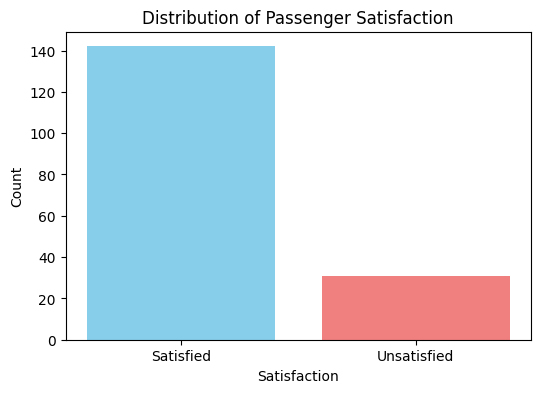

In [99]:
def plot_satisfaction_distribution(satisfaction_scores):
    # Count occurrences of each satisfaction score
    satisfaction_counts = {'Satisfied': sum(score == 1 for score in satisfaction_scores.values()),
                           'Unsatisfied': sum(score == 0 for score in satisfaction_scores.values())}

    # Plot satisfaction distribution
    plt.figure(figsize=(6, 4))
    plt.bar(satisfaction_counts.keys(), satisfaction_counts.values(), color=['skyblue', 'lightcoral'])
    plt.xlabel('Satisfaction')
    plt.ylabel('Count')
    plt.title('Distribution of Passenger Satisfaction')
    plt.show()

# Assuming seat_satisfaction_scores is already calculated
plot_satisfaction_distribution(seat_satisfaction_scores)

# Dynamic model

Generation of a random order of registration

In [ ]:
def Random_order():

    Clefs = list(group_dico.keys())
    Order = random.sample(Clefs, k=len(Clefs))

    return Order

print(Random_order())

[39, 31, 19, 43, 8, 49, 30, 44, 2, 35, 3, 24, 27, 7, 29, 16, 32, 15, 1, 37, 41, 14, 11, 46, 50, 23, 45, 20, 42, 52, 13, 4, 40, 9, 12, 28, 53, 26, 34, 47, 33, 48, 18, 51, 10, 5, 22, 17, 38, 36, 21, 6]


Proposition of seats for the group

In [ ]:
def possible_choice (n_group):

    Choices=[]
    groups_dict =group_dict(Passengers)   #on récupère le dictionnaire {group: [passagers]}
    group = groups_dict[n_group]           #liste des passagers du groupe n°n_group
    group_time=Passengers[group[0]]['connection_time']


    for g in groups_dict:
        if len(groups_dict[g]) == len(group):   #On récupère la position des sièges pour des groupes de même taille
            C=[]
            for i in groups_dict[g]:
                time = Passengers[i]['connection_time']
                #Si le groupe n_group n'est pas en transit, on ne lui propose pas les places des premiers rangs
                if (time == 0 or time > 120) and (group_time ==0 or group_time > 120):    
                    for j in range (1, ns+1):
                        if S[(i,j)].x:
                            C += [j]
                elif (time > 0 and time <= 120) and (group_time > 0 and group_time <= 120):    
                    for j in range (1, ns+1):
                        if S[(i,j)].x:
                            C += [j]
                elif (time == 0 or time > 120) and (group_time > 0 and group_time <= 120):    
                    for j in range (1, ns+1):
                        if S[(i,j)].x:
                            C += [j]

            Choices+=[C]
    
    return Choices

#Il faudra dans une prochaine fonction garder en mémoire les sièges déjà choisis et les supprimer des propositions --> par ex dict avec groupes et sièges choisis par groupe
choices = possible_choice(1)
#print(choices)



def assign_random_values(choices):
    choices_with_values = []

    for choice in choices:
        choices_with_values.append((choice, random.random())) 
    
    return choices_with_values

choices_with_values = assign_random_values(choices)
print(choices_with_values)


[([70, 68, 69], 0.5583112521076209), ([40, 33, 47], 0.4562675812218039), ([78, 79, 80], 0.09765769249066547), ([197, 198, 199], 0.8825103663905985), ([132, 133, 131], 0.7519090414732832), ([29, 37, 36], 0.39023643426787324)]


In [ ]:
def group_choices(choices_with_values):

    sorted_choices = sorted(choices_with_values, key=lambda x: x[1], reverse=True)
    group_choices = [choice[0] for choice in sorted_choices]
    
    return group_choices


group_choices_sorted = group_choices(choices_with_values)
print(group_choices_sorted)


[[197, 198, 199], [132, 133, 131], [70, 68, 69], [40, 33, 47], [29, 37, 36], [78, 79, 80]]


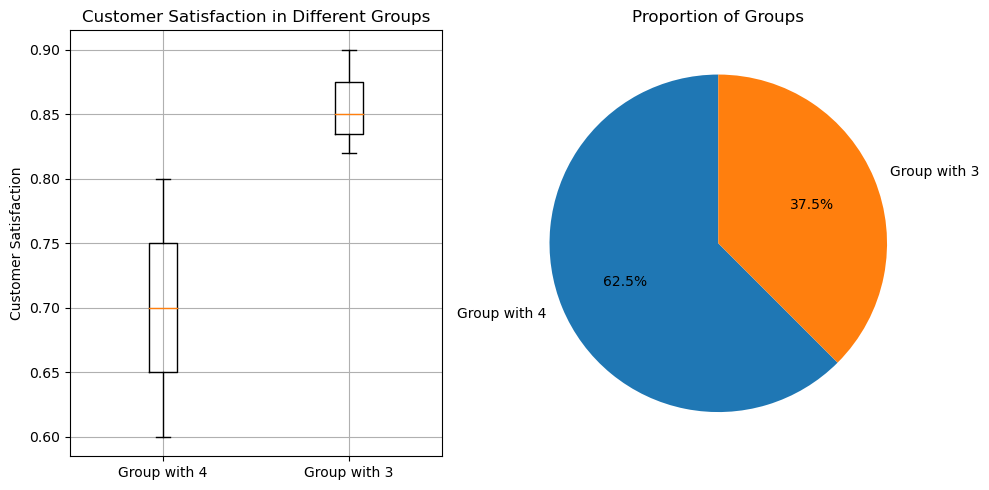

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Customer satisfaction data for the two groups
satisfaction_group_4 = [0.8, 0.7, 0.6, 0.65, 0.75] 
satisfaction_group_3 = [0.9, 0.85, 0.82]            

# Creating a figure and axes for the boxplot and pie chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Data for the boxplot
data = [satisfaction_group_4, satisfaction_group_3]

# Creating the boxplot
boxplot = ax1.boxplot(data)

# Adding labels to the axes
ax1.set_xticklabels(['Group with 4', 'Group with 3'])
ax1.set_ylabel('Customer Satisfaction')
ax1.set_title('Customer Satisfaction in Different Groups')
ax1.grid(True)

# Data for the pie chart
group_sizes = [len(satisfaction_group_4), len(satisfaction_group_3)]
group_labels = ['Group with 4', 'Group with 3']

# Creating the pie chart
ax2.pie(group_sizes, labels=group_labels, autopct='%1.1f%%', startangle=90)
ax2.set_title('Proportion of Groups')

# Equal aspect ratio ensures that pie is drawn as a circle
ax2.axis('equal')

# Displaying the plots
plt.tight_layout()
plt.show()


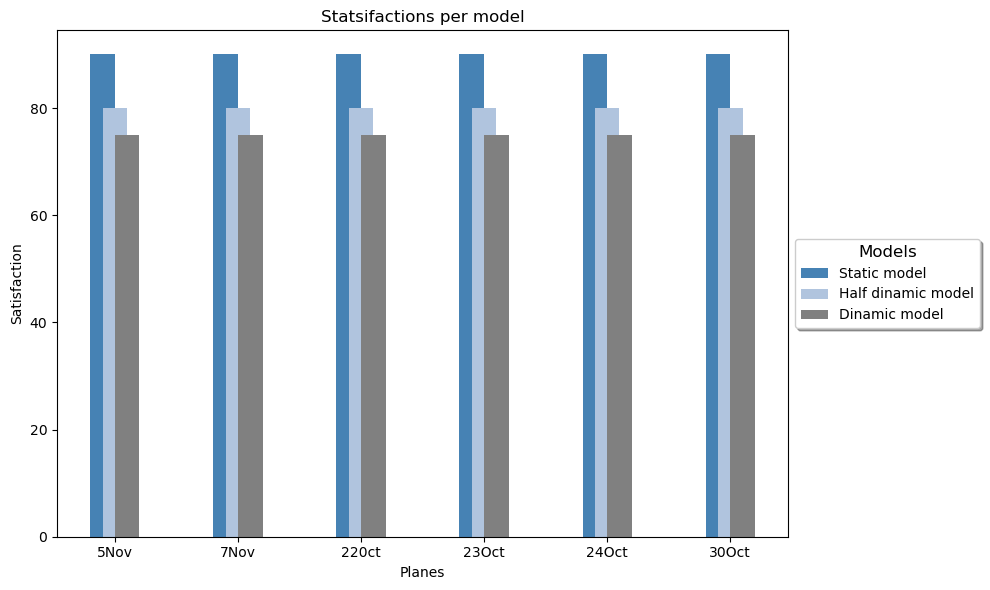

In [ ]:
# Data for the variables
variables = ['5Nov', '7Nov', '220ct', '23Oct', '24Oct', '30Oct']
scores1 = [90, 90, 90, 90, 90, 90]  # Scores for the static model 
scores2 = [80, 80, 80, 80, 80, 80]  # Scores for the half dinamic model
scores3 = [75, 75, 75, 75, 75, 75]  # Scores for the dinamic model


# Creating a figure and an axis with an adjusted figure size
fig, ax = plt.subplots(figsize=(10, 6))  # Increased figure size

# Setting the width of the bars
bar_width = 0.2
bar_spacing = 0.1  # Reduced bar spacing

# Creating bars for each condition
index = np.arange(len(variables))
bar1 = ax.bar(index - bar_spacing, scores1, bar_width, color='steelblue', label='Static model')
bar2 = ax.bar(index, scores2, bar_width, color='lightsteelblue', label='Half dinamic model')
bar3 = ax.bar(index + bar_spacing, scores3, bar_width, color='gray', label='Dinamic model')

# Adding labels to the axes and title
ax.set_xlabel('Planes')
ax.set_ylabel('Satisfaction')
ax.set_title('Statsifactions per model')
ax.set_xticks(index)
ax.set_xticklabels(variables)
ax.legend()

# Displaying the concatenated bar chart
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Models", title_fontsize="large", fontsize="medium", shadow=True, fancybox=True)  # Adjust legend position using bbox
plt.tight_layout()
plt.show()


In [ ]:
def dynamic_model(m):
    order = Random_order()
    for group in order:
        possible_seats=possible_choice(group)
        choice=group_choice()
        
